In [26]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#root_path = '/content/gdrive/My Drive/Colab Notebooks/MyModel'
#import sys
#sys.path.append(root_path)
#https://github.com/huyvnphan/PyTorch-CIFAR10/blob/master/CIFAR10.ipynb

In [1]:
# pytorch
import torch
import torchvision
from torchvision import models
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import torch.distributions as td

# operations
import itertools
import pandas as pd
import time
import os

#plots
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.image as mpimg
from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage, AnnotationBbox)
from matplotlib.cbook import get_sample_data
from matplotlib import rcParams

#math
import numpy as np
from numpy.random import random
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from scipy.linalg import sqrtm

#modules
from cifar10_models import resnet
import data_loader
import visualize
import train_model
import FGSM
import augment
import utility
import detect_adversarials
from temperature_scaling import ModelWithTemperature


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Files already downloaded and verified
Files already downloaded and verified
Size of training set: 50000
Size of validation set: 7500
Size of test set: 2500


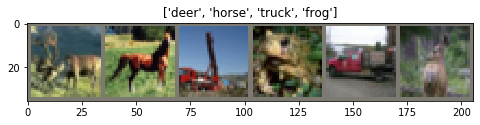

In [2]:
#LOAD DATA
batch_size=100
trainloader, validloader, testloader, attributes=data_loader.load_cifar10(batch_size, valid_ratio=.75)
N_test=attributes["N_test"]
N_train=attributes["N_train"]
N_valid = attributes["N_valid"]
classes=attributes["class_names"]
print("Size of training set: {}".format(N_train))
print("Size of validation set: {}".format(N_valid))
print("Size of test set: {}".format(N_test))
# VISUALIZE
inputs, class_data = next(iter(trainloader))
rcParams['figure.figsize'] = [8.0, 6.0]
visualize.imshow(inputs[:6], title=[classes[i] for i in class_data[:4]], savefigure="example1")

Now doing the augmentation of the images, let us illustrate it with flipping the images.

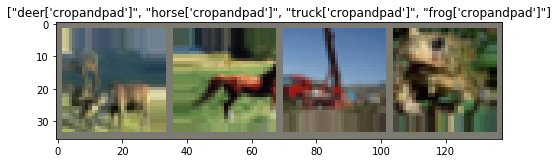

In [10]:
rcParams['figure.figsize'] = [8.0, 6.0]

aug_batches, aug_seqs, aug_seqs_names = augment.compute_augmentations(inputs[:4], n = 1, depth = 1, augmentations="cropandpad", flip_p=0, rot=30, br_add=40)
for i, _ in enumerate(aug_seqs_names):
    visualize.imshow(aug_batches[i], title=[classes[j]+str(aug_seqs_names[i]) for j in class_data[:4]], savefigure="example2")

Loading the pretrained ResNet model:

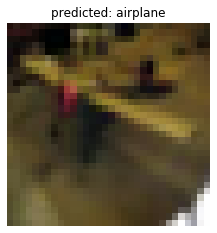

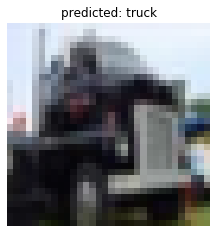

In [11]:
# load the pretrained resnet 18/34 or 50
path="cifar10_models/state_dicts/resnet50.pt"
model = resnet.resnet50(pretrained=True).to(device)
# train if necessary
# model_ft = train_model.train(model, trainloader, testloader,num_epochs=2)

model.load_state_dict(torch.load(path,map_location=torch.device('cpu')))
model.eval()
visualize.visualize_model(model, testloader, classes, num_images=2)

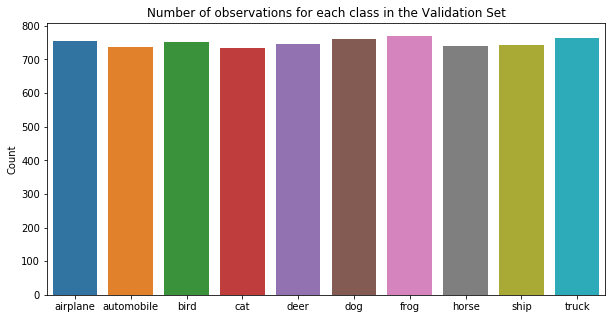

In [12]:
classes = np.array([])
for _, img_class in iter(validloader):
    classes = np.concatenate((classes,img_class.numpy()))
fig, ax = plt.subplots(figsize =(10,5))
sns.countplot(classes, ax= ax)
ax.set_title("Number of observations for each class in the Validation Set")
plt.xticks([0,1,2,3,4,5,6,7,8,9],labels = attributes["class_names"])
ax.set_ylabel("Count")
plt.show()

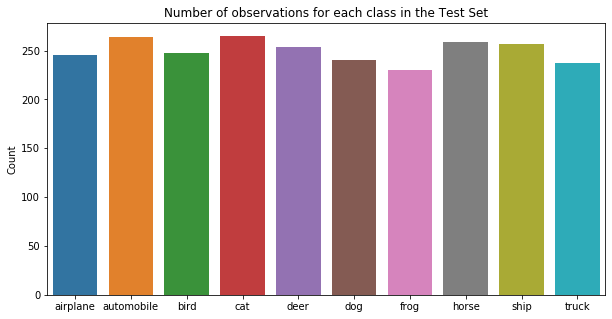

In [13]:
classes = np.array([])
for _, img_class in iter(testloader):
    classes = np.concatenate((classes,img_class.numpy()))
fig, ax = plt.subplots(figsize =(10,5))
sns.countplot(classes, ax= ax)
ax.set_title("Number of observations for each class in the Test Set")
plt.xticks([0,1,2,3,4,5,6,7,8,9],labels = attributes["class_names"])
ax.set_ylabel("Count")
plt.show()

### Model accuracy - Some of samueles code

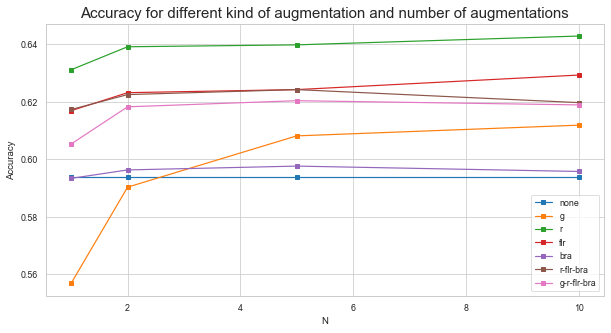

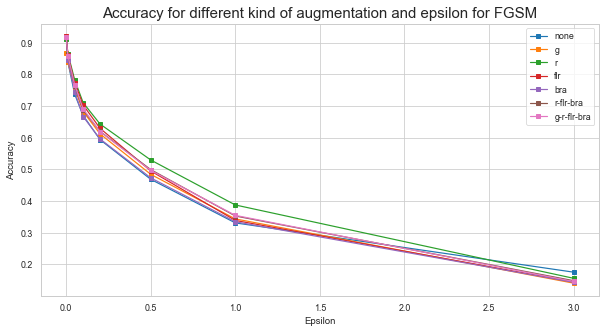

In [31]:
df = pd.read_csv("log.csv", header = 0)


sns.set_context("paper")
fig, ax = plt.subplots(figsize = (10,5))
ax.set_title("Accuracy for different kind of augmentation and number of augmentations", fontsize=15)
for aug in pd.unique(df["augs"]):
    df[(df["epsilon"] == 0.2)&(df["augs"] == aug)].plot(x = "n", y = "accuracy", ax = ax, label=aug, style = "-s")
ax.set_ylabel("Accuracy")
ax.set_xlabel("N")
plt.savefig("accuracyplot.png",bbox_inches='tight',dpi=100)

sns.set_context("paper")
fig, ax = plt.subplots(figsize = (10,5))
ax.set_title("Accuracy for different kind of augmentation and epsilon for FGSM", fontsize=15)
for aug in pd.unique(df["augs"]):
    df[(df["n"] == 10)&(df["augs"] == aug)].plot(x = "epsilon", y = "accuracy", ax = ax, label=aug, style = "-s")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epsilon")
plt.savefig("accuracyplot.png",bbox_inches='tight',dpi=100)



## The FGSM attack

Let us look at when it is possible for the human eye to detect an FGSM attack.

In [14]:
eps = [0, 0.01, 0.05, 0.1, 0.2, 0.5, 1,3]

In [15]:
epsilon_images = []
original_images = []
l2_norms_images = []
for i in eps:
    adv_examples, original_input=FGSM.get_examples_fgsm(model, validloader, epsilon=i, limit=10)
    epsilon_images.append(adv_examples[0])
    original_images.append(original_input[0])
    diff = original_input-adv_examples
    l2_norms = torch.norm(diff.view(diff.shape[0], -1), p=2, dim=1)
    avg_l2norm = torch.mean(l2_norms, dim=0)
    l2_norms_images.append(round(l2_norms[0].item(),3))

Around $\epsilon=0.2$ it is possible to detect noise from the FGSM attack in the image

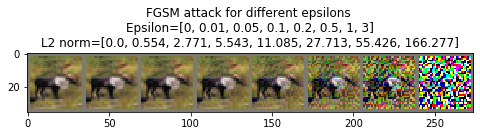

In [16]:
plt.grid(False)
visualize.imshow(epsilon_images, title="FGSM attack for different epsilons \nEpsilon="+str(eps)+"\nL2 norm="+str(l2_norms_images), savefigure="fgsm_eps")

Temperature Scaling

In [17]:
scaled_model = ModelWithTemperature(model)
structure=scaled_model.set_temperature(validloader)
temperature=structure.temperature

Before temperature - NLL: 0.251, ECE: 0.037
Optimal temperature: 1.500
After temperature - NLL: 0.206, ECE: 0.013


Looking at the model accuracy below it is clear that an attack makes the model accuracy a lot worse. Let us investigate how confident the model is with its predictions, e.g. does the model show large uncertainty when the adversarial attack occur?

Epsilon: 0	Test Accuracy = 7067 / 7500 = 0.9422666666666667
Expected Calibration Error: 0.04012545198202133
Epsilon: 0	Test Accuracy = 7067 / 7500 = 0.9422666666666667
Expected Calibration Error: 0.010363617911934853


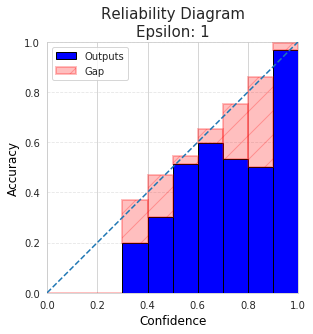

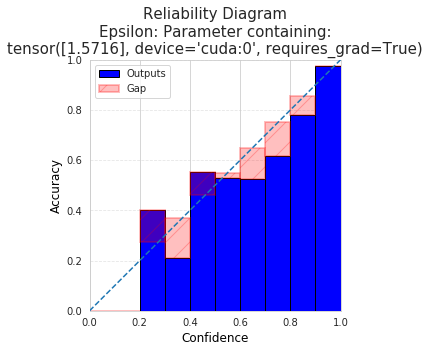

In [68]:
final_accuracy = []
temperature_test = [1, temperature]
for count,i in enumerate(temperature_test):
    final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 0, 
                                                                             epsilon=0,
                                                                             augmentations = "none", n = 1, temperature=i)
    # Get statistics
    pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
    # Get ECE and bins
    ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
    title = "Reliability Diagram\nEpsilon: {}".format(i)
    figure = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title, plot_n=count)
    print("Expected Calibration Error: {}".format(ece))
    #figures.append(figure)
    final_accuracy.append(final_acc)

Epsilon: 0	Test Accuracy = 7021 / 7500 = 0.9361333333333334
Expected Calibration Error: 0.01767336018383503
Epsilon: 0.01	Test Accuracy = 6286 / 7500 = 0.8381333333333333
Expected Calibration Error: 0.0911133736371994
Epsilon: 0.05	Test Accuracy = 4418 / 7500 = 0.5890666666666666
Expected Calibration Error: 0.31680214405059814
Epsilon: 0.1	Test Accuracy = 3578 / 7500 = 0.4770666666666667
Expected Calibration Error: 0.41232892870903015
Epsilon: 0.2	Test Accuracy = 2788 / 7500 = 0.37173333333333336
Expected Calibration Error: 0.48505479097366333
Epsilon: 0.5	Test Accuracy = 1277 / 7500 = 0.17026666666666668
Expected Calibration Error: 0.5934042930603027
Epsilon: 1	Test Accuracy = 814 / 7500 = 0.10853333333333333
Expected Calibration Error: 0.5237219333648682
Epsilon: 3	Test Accuracy = 831 / 7500 = 0.1108
Expected Calibration Error: 0.43651270866394043


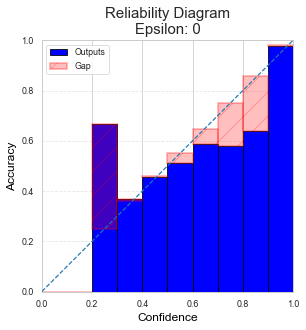

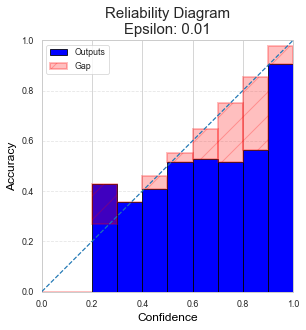

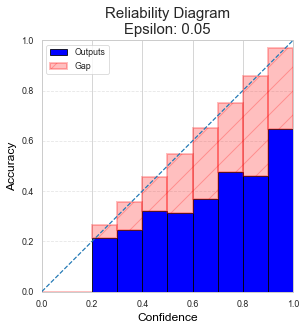

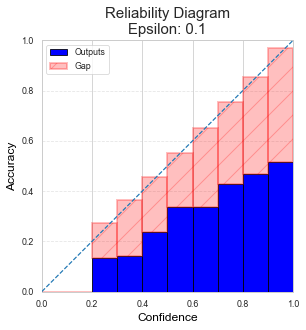

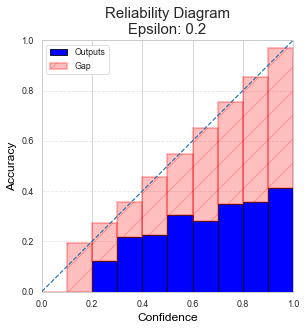

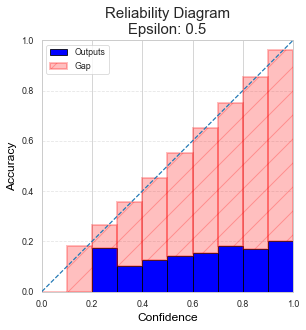

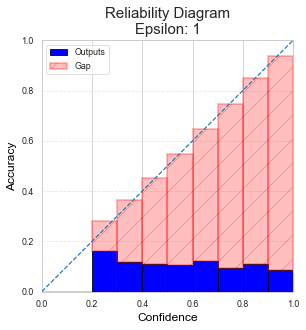

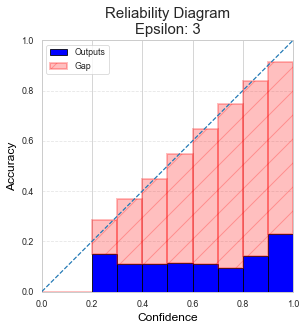

In [40]:
#### figures=[]
final_accuracy = []
eps = [0, 0.01, 0.05, 0.1, 0.2, 0.5, 1,3]
for count,i in enumerate(eps):
    final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 0, 
                                                                             epsilon=i,
                                                                             augmentations = "none", n = 1, temperature=temperature)
    # Get statistics
    pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
    # Get ECE and bins
    ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
    title = "Reliability Diagram\nEpsilon: {}".format(i)
    figure = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title, plot_n=count)
    print("Expected Calibration Error: {}".format(ece))
    #figures.append(figure)
    final_accuracy.append(final_acc)
    

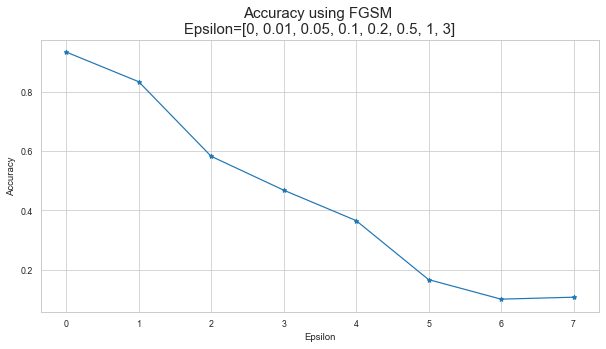

In [13]:
import seaborn as sns
sns.set_context("paper")
fig, ax = plt.subplots(figsize = (10,5))
ax.set_title("Accuracy using FGSM \nEpsilon="+str(eps), fontsize=15)
ax.plot(final_accuracy, "*-")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epsilon")
plt.savefig("accuracyplot.png",bbox_inches='tight',dpi=100)

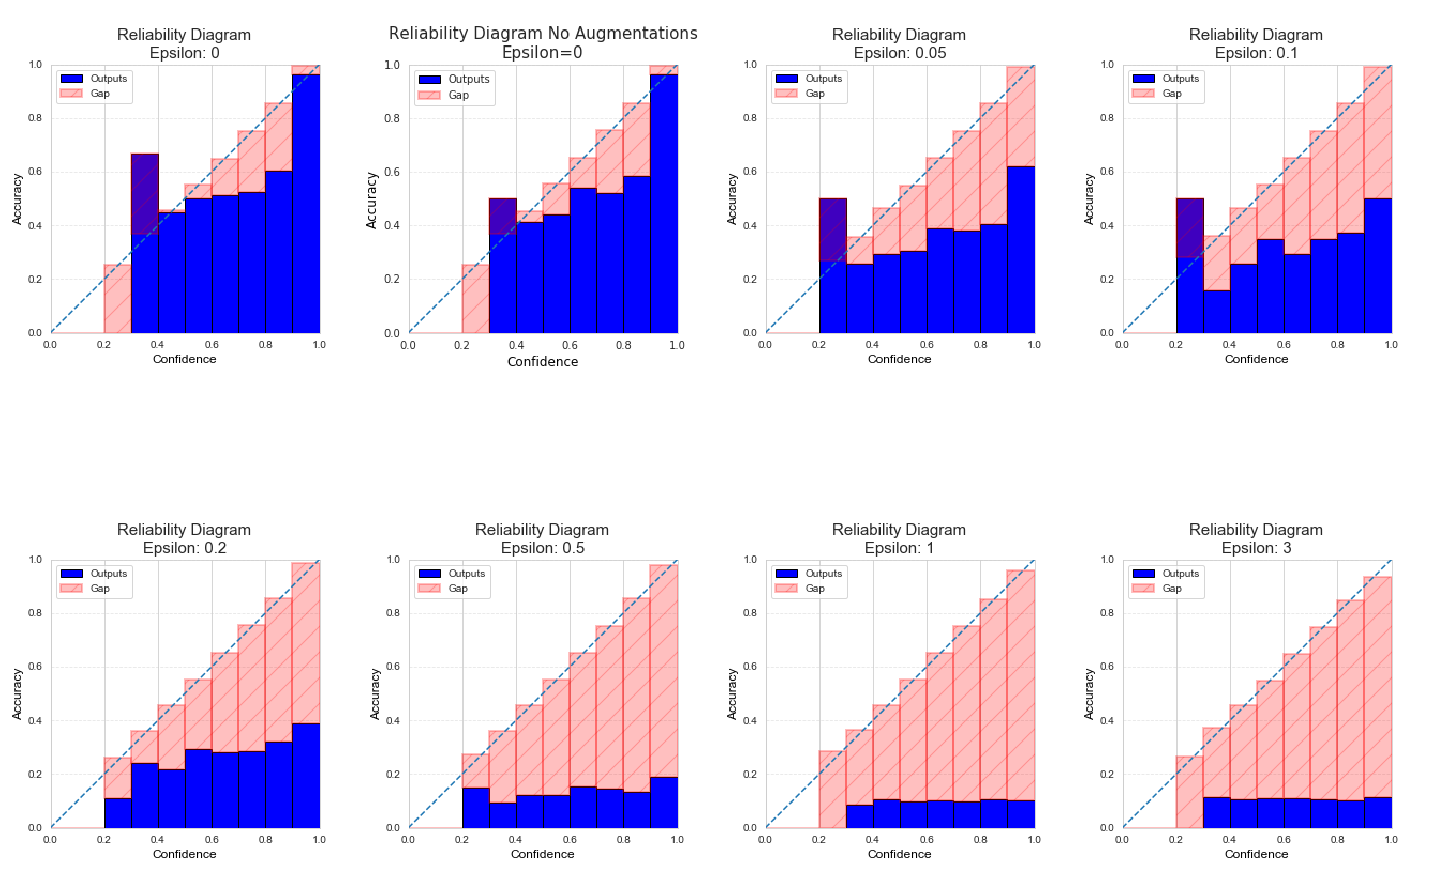

In [6]:
%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = 20 ,20
n_img=len(figures)
row=0
fig, ax = plt.subplots(2,4)
for i in range(n_img):
    # read images
    img = mpimg.imread("figures/"+"reliability_diagram_"+str(i)+".png")
    if i==4:
        row+=1
    if i>=4:
        i-=4
    # display images
    ax[row,i].axis('off')
    ax[row,i].imshow(img);
    plt.tight_layout()


We see that the accuracy gets worse and worse, but the confidence remains the same for an increasing $\epsilon$! The model needs to be calibrated.

## Introducing augmentations

20%
40%
60%
80%
100%
Epsilon: 0.2	Test Accuracy = 3249 / 7500 = 0.4332


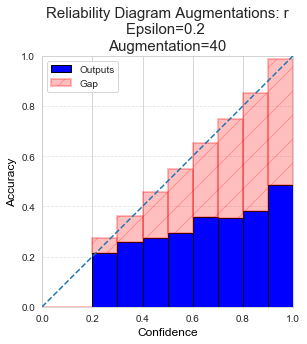

In [86]:
augmentations_list = ["none","g", "r", "flr", "bra", "r,flr,bra", "g,r,flr,bra"]
n_augs = [1,2,5,10]
eps = [0, 0.01, 0.05, 0.1, 0.2, 0.5, 1,3]
figures=[]
results = []
n_augs = [40]
eps =[0.2]

for aug in augmentations_list:
    for n in n_augs:
        for epsilon in eps:
            final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 1, 
                                                                             epsilon=epsilon,
                                                                             augmentations = aug,
                                                                             n = n)
            #some statistics if necessary
            pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
            #get ece and bins
            ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
            #plot it
            if aug == "none":
                title = "Reliability Diagram No Augmentations\nEpsilon={}".format(epsilon)
            else:
                title = "Reliability Diagram Augmentations: {}\nEpsilon={} \nAugmentation={}".format(aug, epsilon,n)
            fig = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title)
            results.append({"augments":aug,"n":n,"epsilon":epsilon,"accuracy":final_acc,"ece":ece,"figure":fig})
            plt.figure(fig.number)
            plt.savefig("figures/reliability_diagram-n{}-aug{}-epsilon{}.png".format(n,aug.replace(",","-"),epsilon),bbox_inches='tight',dpi=100)
            break
            
        break
    break
    

20%
40%
60%
80%
100%
Epsilon: 0	Test Accuracy = 7090 / 7500 = 0.9453333333333334


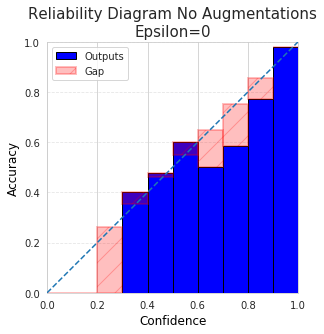

In [19]:
epsilon = 0
aug = "none"
n = 1
final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(scaled_model, validloader, v = 1, 
                                                                             epsilon=epsilon,
                                                                             augmentations = aug,
                                                                             n = n)
#some statistics if necessary
pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
#get ece and bins
ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
#plot it
if aug == "none":
    title = "Reliability Diagram No Augmentations\nEpsilon={}".format(epsilon)
else:
    title = "Reliability Diagram Augmentations: {}\nEpsilon={} \nAugmentation={}".format(aug, epsilon,n)
fig = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title)
plt.figure(fig.number)
plt.show()

20%
40%
60%
80%
100%
Epsilon: 0.2	Test Accuracy = 3261 / 7500 = 0.4348


NameError: name 'results' is not defined

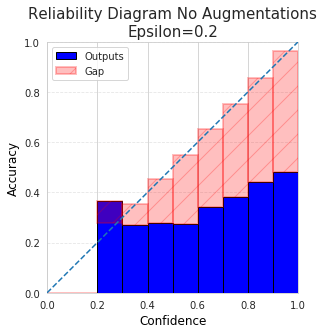

In [18]:
epsilon = 0.2
aug = "none"
n = 1
final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(scaled_model, validloader, v = 1, 
                                                                             epsilon=epsilon,
                                                                             augmentations = aug,
                                                                             n = n)
#some statistics if necessary
pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
#get ece and bins
ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
#plot it
if aug == "none":
    title = "Reliability Diagram No Augmentations\nEpsilon={}".format(epsilon)
else:
    title = "Reliability Diagram Augmentations: {}\nEpsilon={} \nAugmentation={}".format(aug, epsilon,n)
fig = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title)
plt.figure(fig.number)
plt.show()

20%
40%
60%
80%
100%
Epsilon: 0.2	Test Accuracy = 3877 / 7500 = 0.5169333333333334


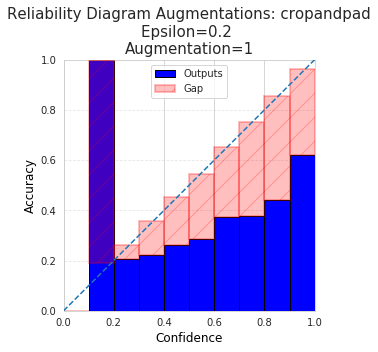

In [20]:
epsilon = 0.2
aug = "cropandpad"
n = 1
final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(scaled_model, validloader, v = 1, 
                                                                             epsilon=epsilon,
                                                                             augmentations = aug,
                                                                             n = n)
#some statistics if necessary
pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
#get ece and bins
ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
#plot it
if aug == "none":
    title = "Reliability Diagram No Augmentations\nEpsilon={}".format(epsilon)
else:
    title = "Reliability Diagram Augmentations: {}\nEpsilon={} \nAugmentation={}".format(aug, epsilon,n)
fig = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title)
plt.figure(fig.number)
plt.show()

20%
40%
60%
80%
100%
Epsilon: 0.2	Test Accuracy = 3785 / 7500 = 0.5046666666666667


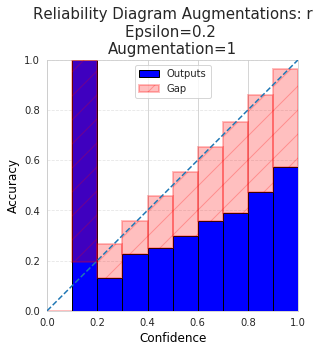

In [21]:
epsilon = 0.2
aug = "r"
n = 1
final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(scaled_model, validloader, v = 1, 
                                                                             epsilon=epsilon,
                                                                             augmentations = aug,
                                                                             n = n)
#some statistics if necessary
pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
#get ece and bins
ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
#plot it
if aug == "none":
    title = "Reliability Diagram No Augmentations\nEpsilon={}".format(epsilon)
else:
    title = "Reliability Diagram Augmentations: {}\nEpsilon={} \nAugmentation={}".format(aug, epsilon,n)
fig = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title)
plt.figure(fig.number)
plt.show()

In [ ]:
epsilon = 0.2
aug = "r"
n = 1
final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(scaled_model, validloader, v = 1, 
                                                                             epsilon=epsilon,
                                                                             augmentations = aug,
                                                                             n = n)
#some statistics if necessary
pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
#get ece and bins
ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
#plot it
if aug == "none":
    title = "Reliability Diagram No Augmentations\nEpsilon={}".format(epsilon)
else:
    title = "Reliability Diagram Augmentations: {}\nEpsilon={} \nAugmentation={}".format(aug, epsilon,n)
fig = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title)
plt.figure(fig.number)
plt.show()

In [48]:
print(fig)
plt.figure(fig.number)
plt.savefig("figures_20200422/reliability_diagram-n{}-aug{}-epsilon{}.png".format(n,aug.replace(",","-"),epsilon),bbox_inches='tight',dpi=100)

Figure(324x360)


<Figure size 432x288 with 0 Axes>

In [ ]:
import pandas as pd
import pickle

#df = pd.DataFrame(results)
#df.to_pickle("results_20200409.pandaspickle")
#df.head(140)
df.to_csv("results_20200409.csv")

## Looking at invariance of augmentations

To do this the FID score is used to compare how much the different augmentations affect the model.

In [11]:
#used to illustrate examples.
n_batches = 2
inputs_arr = []
iter_dataloader = iter(trainloader)
for _ in range(n_batches):
    cur_inputs, c =  next(iter_dataloader)
    inputs_arr.append(cur_inputs)
    
inputs = torch.cat(inputs_arr, dim = 0)
inputs.shape

# get model features
model_features, p = utility.get_features(model)

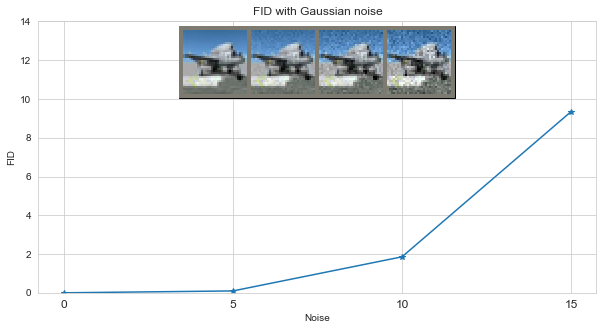

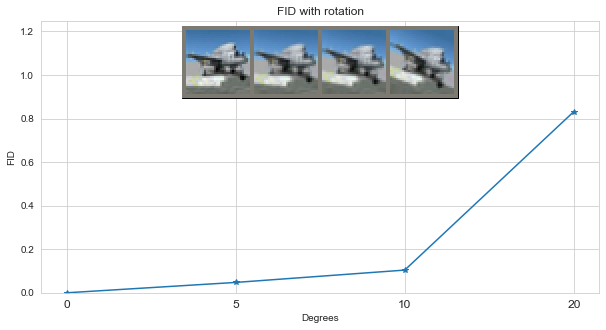

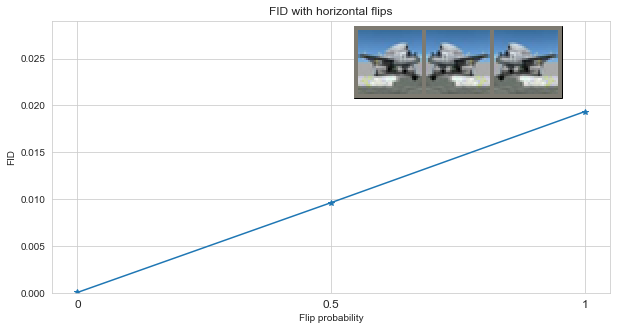

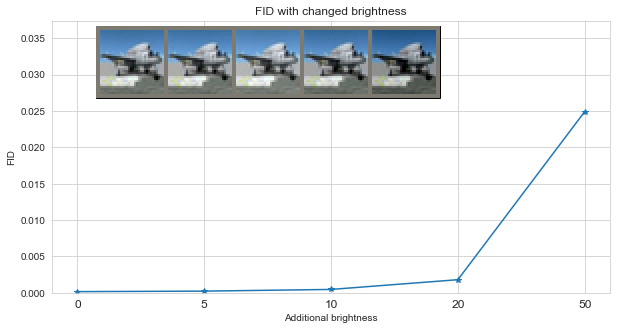

In [21]:
expansion=False
if expansion == True:
    bottleneck=True
else:
    bottleneck=False
    
params = [0,5,10,15]
FID, plot_batch = utility.get_FID(inputs, model_features, device, augmentation="g", noise_level=params, bottleneck=bottleneck)
utility.plot_fid(FID, plot_batch, x_labels=params, title = "FID with Gaussian noise",plot_n="gaus_aug_fid.png")

params = [0,5,10,20]
FID, plot_batch = utility.get_FID(inputs, model_features, device, augmentation="r", noise_level=params, bottleneck = bottleneck)
utility.plot_fid(FID, plot_batch, x_labels=params, title="FID with rotation", xlabel="Degrees",plot_n="rot_aug_fid.png")

params = [0,0.5,1]
FID, plot_batch = utility.get_FID(inputs, model_features, device, augmentation="flr", noise_level=params, bottleneck = bottleneck)
utility.plot_fid(FID, plot_batch, x_labels=params, title = "FID with horizontal flips", xlabel="Flip probability",plot_n="flr_aug_fid.png")

params = [0,5,10,20,50]
FID, plot_batch = utility.get_FID(inputs, model_features, device, augmentation="bra", noise_level=params, bottleneck = bottleneck)
utility.plot_fid(FID, plot_batch, x_labels=params, title="FID with changed brightness", xlabel="Additional brightness", plot_n="bright_aug_fid.png")

It is observed that the FID increases very little using augmentations such as brightness, rotation and flipping the image, indicating invariance towards these augmentations. The gaussian noise affects the model a lot. It might not be a good idea to introduce gaussian noise as a defense against adversarial attacks.

## Calibration when using augmentations

Let us look how calibration is affected when using augmentations

Epsilon: 0	Test Accuracy = 6862 / 7500 = 0.9149333333333334
Expected Calibration Error: 0.027849141508340836
Epsilon: 0	Test Accuracy = 4781 / 7500 = 0.6374666666666666
Expected Calibration Error: 0.24722033739089966
Epsilon: 0	Test Accuracy = 7027 / 7500 = 0.9369333333333333
Expected Calibration Error: 0.01728413812816143
Epsilon: 0	Test Accuracy = 6991 / 7500 = 0.9321333333333334
Expected Calibration Error: 0.02062229998409748
Epsilon: 0	Test Accuracy = 7018 / 7500 = 0.9357333333333333
Expected Calibration Error: 0.017273377627134323
Epsilon: 0	Test Accuracy = 6951 / 7500 = 0.9268
Expected Calibration Error: 0.022600039839744568
Epsilon: 0	Test Accuracy = 6920 / 7500 = 0.9226666666666666
Expected Calibration Error: 0.02478116750717163
Epsilon: 0	Test Accuracy = 5885 / 7500 = 0.7846666666666666
Expected Calibration Error: 0.13560426235198975


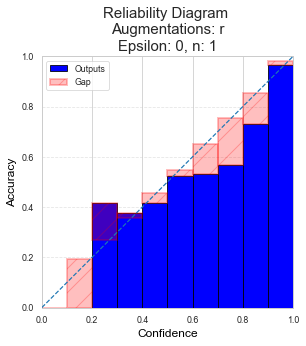

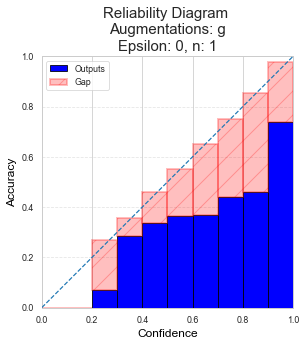

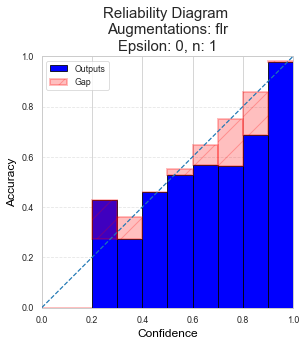

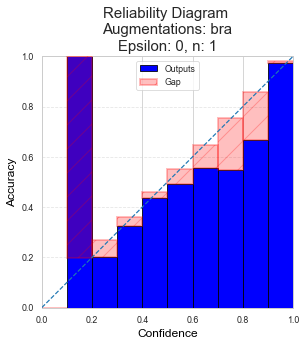

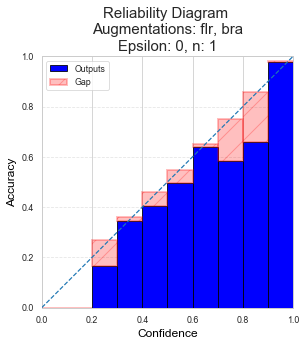

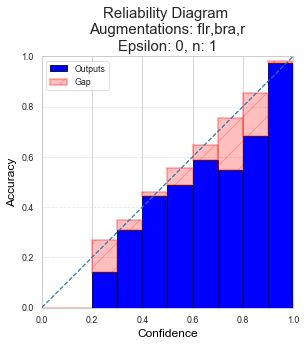

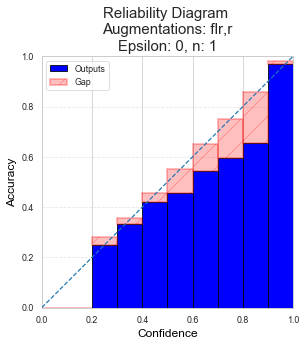

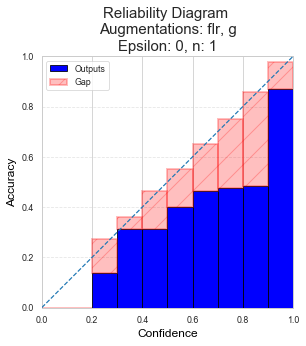

In [41]:
figures=[]
aug = ["r", "g","flr", "bra", "flr, bra", "flr,bra,r", "flr,r", "flr, g"]
n=1

for count,i in enumerate(aug):
    final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 0, 
                                                                             epsilon=0,
                                                                             augmentations = i, n = n, temperature=temperature);
    # Get statistics
    pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
    # Get ECE and bins
    ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
    title = "Reliability Diagram \nAugmentations: {}\nEpsilon: {}, n: {}".format(i, 0, n)
    figure = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title, plot_n=str(count)+"aug")
    print("Expected Calibration Error: {}".format(ece))
    plt.savefig("figures/"+"reliability_diagram_"+str(count)+"aug"+".png",bbox_inches='tight',dpi=100)
    figures.append(figure)
    

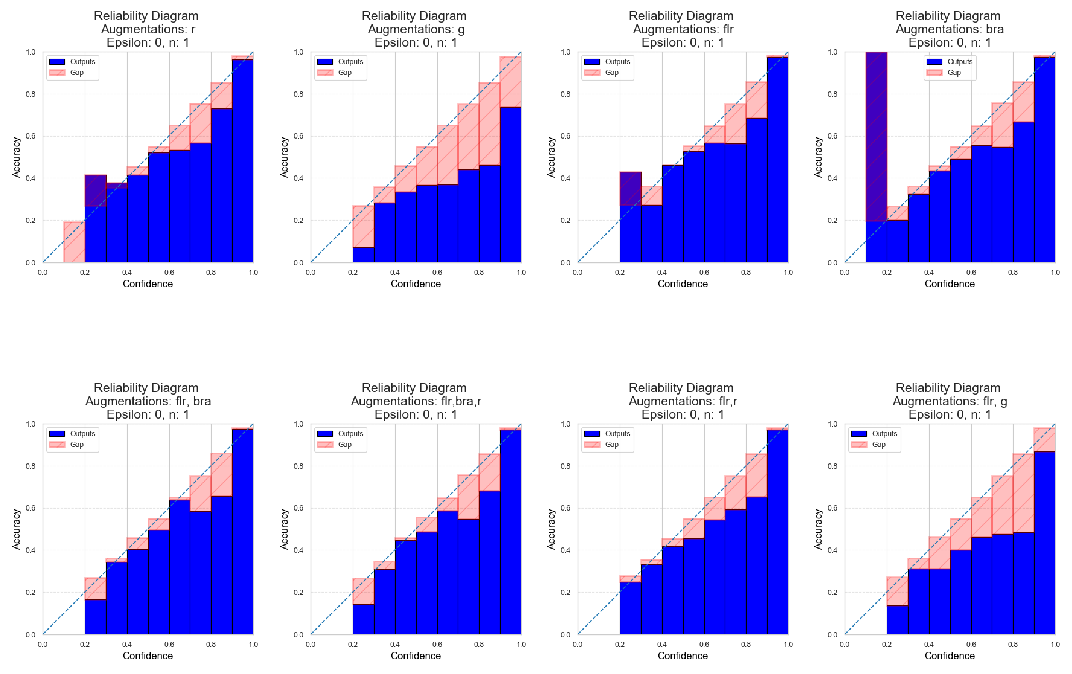

In [42]:
%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = 15 ,15
n_img=len(figures)
row=0
fig, ax = plt.subplots(2,4)
for i in range(n_img):
    # read images
    img = mpimg.imread("figures/"+"reliability_diagram_"+str(i)+"aug"+".png")
    if i==4:
        row+=1
    if i>=4:
        i-=4
    # display images
    ax[row,i].axis('off')
    ax[row,i].imshow(img);
    plt.tight_layout()


Changing n and eps:

Epsilon: 0	Test Accuracy = 7005 / 7500 = 0.934
Expected Calibration Error: 0.04394693672657013
Epsilon: 0	Test Accuracy = 7033 / 7500 = 0.9377333333333333
Expected Calibration Error: 0.03439955413341522
Epsilon: 0	Test Accuracy = 7032 / 7500 = 0.9376
Expected Calibration Error: 0.03239213675260544
Epsilon: 0	Test Accuracy = 7037 / 7500 = 0.9382666666666667
Expected Calibration Error: 0.031129013746976852
Epsilon: 0	Test Accuracy = 7029 / 7500 = 0.9372
Expected Calibration Error: 0.03121340461075306
Epsilon: 0	Test Accuracy = 7045 / 7500 = 0.9393333333333334
Expected Calibration Error: 0.02842927724123001
Epsilon: 0	Test Accuracy = 7035 / 7500 = 0.938
Expected Calibration Error: 0.02948153391480446
Epsilon: 0	Test Accuracy = 7028 / 7500 = 0.9370666666666667
Expected Calibration Error: 0.03057190775871277


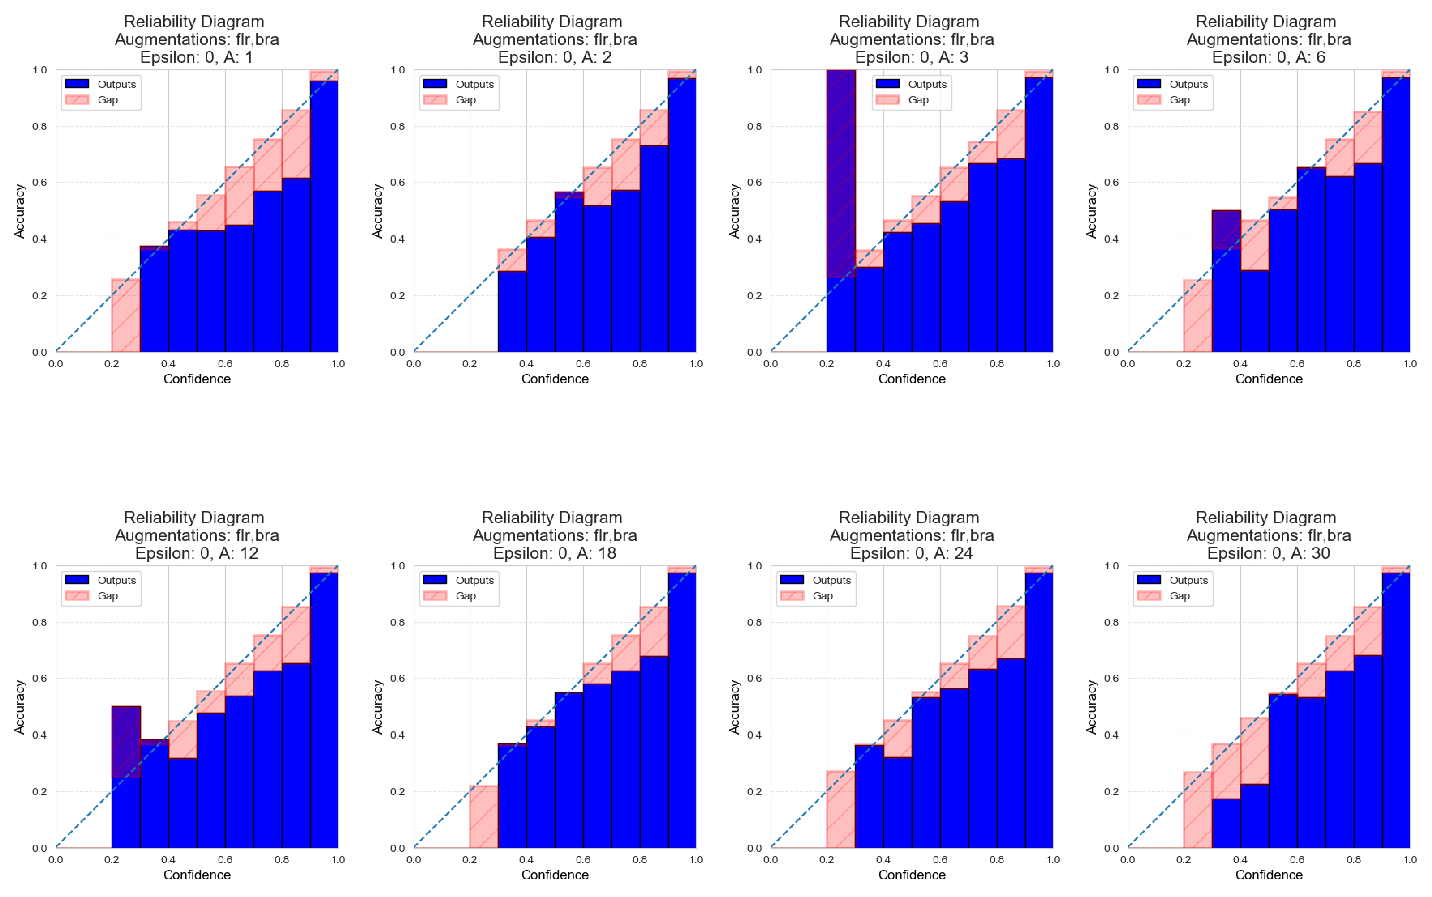

In [106]:
figures=[]
aug = "flr,bra"
n=[1,2,3,6,12,18,24,30]

for count,i in enumerate(n):
    final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 0, 
                                                                             epsilon=0,
                                                                             augmentations = aug, n = i, temperature=temperature);
    # Get statistics
    pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
    # Get ECE and bins
    ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
    title = "Reliability Diagram \nAugmentations: {}\nEpsilon: {}, A: {}".format(aug, 0, i)
    figure = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title, plot_n=str(count)+"_n")
    print("Expected Calibration Error: {}".format(ece))
    figures.append(figure)
    plt.savefig("figures/"+"reliability_diagram_"+str(count)+"_n"+".png",bbox_inches='tight',dpi=100)
    
%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = 15 ,15
n_img=len(figures)
row=0
fig, ax = plt.subplots(2,4)
for i in range(n_img):
    # read images
    img = mpimg.imread("figures/"+"reliability_diagram_"+str(i)+"_n"+".png")
    if i==4:
        row+=1
    if i>=4:
        i-=4
    # display images
    ax[row,i].axis('off')
    ax[row,i].imshow(img);
    plt.tight_layout()

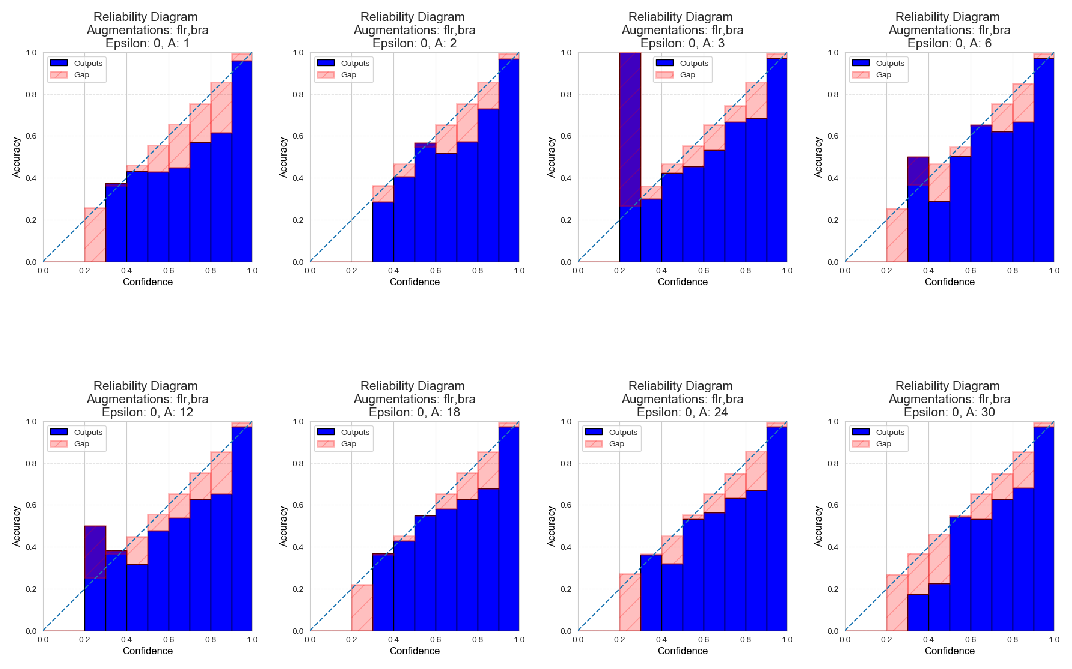

Looking at epsilon with augmentations and n:

Epsilon: 0	Test Accuracy = 7034 / 7500 = 0.9378666666666666
Expected Calibration Error: 0.03305981680750847
Epsilon: 0.01	Test Accuracy = 6449 / 7500 = 0.8598666666666667
Expected Calibration Error: 0.09150530397891998
Epsilon: 0.05	Test Accuracy = 4710 / 7500 = 0.628
Expected Calibration Error: 0.2987602651119232
Epsilon: 0.1	Test Accuracy = 3688 / 7500 = 0.49173333333333336
Expected Calibration Error: 0.4241327941417694
Epsilon: 0.2	Test Accuracy = 2999 / 7500 = 0.39986666666666665
Expected Calibration Error: 0.48657768964767456
Epsilon: 0.5	Test Accuracy = 1348 / 7500 = 0.17973333333333333
Expected Calibration Error: 0.6355416774749756
Epsilon: 1	Test Accuracy = 831 / 7500 = 0.1108
Expected Calibration Error: 0.6136330366134644
Epsilon: 3	Test Accuracy = 782 / 7500 = 0.10426666666666666
Expected Calibration Error: 0.6071785092353821


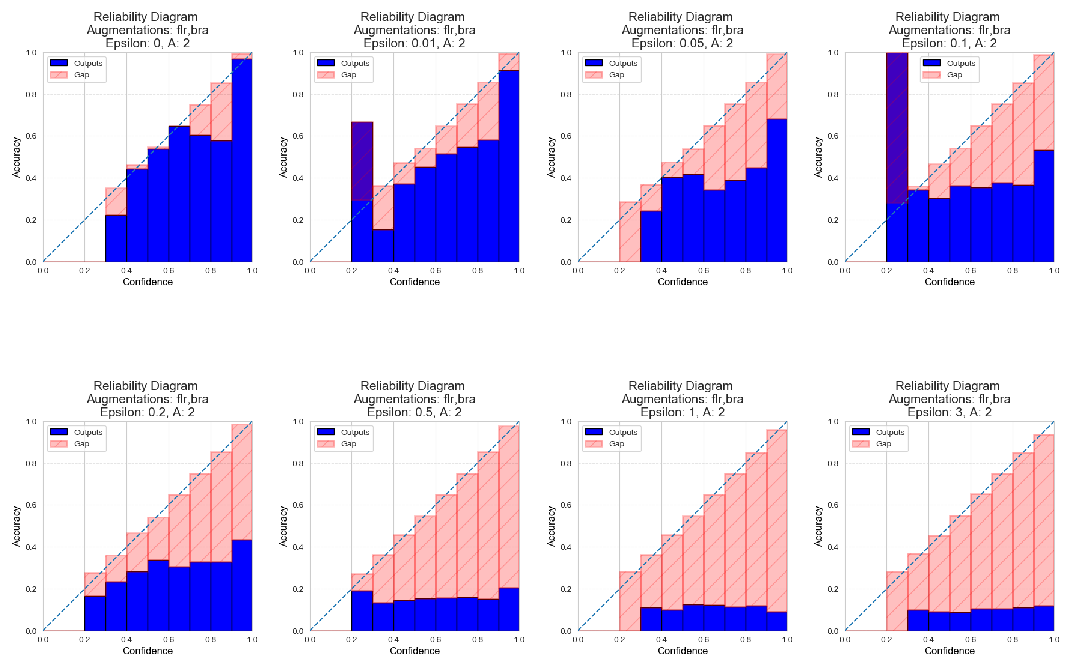

In [110]:
figures=[]
aug = "flr,bra"
n=2
eps=[0, 0.01, 0.05, 0.1, 0.2, 0.5, 1,3]

for count,i in enumerate(eps):
    final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 0, 
                                                                             epsilon=i,
                                                                             augmentations = aug, n = n, temperature=temperature);
    # Get statistics
    pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
    # Get ECE and bins
    ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
    title = "Reliability Diagram \nAugmentations: {}\nEpsilon: {}, A: {}".format(aug, i, n)
    figure = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title, plot_n=str(count)+"_eps")
    print("Expected Calibration Error: {}".format(ece))
    figures.append(figure)
    plt.savefig("figures/"+"reliability_diagram_"+str(count)+"_eps"+".png",bbox_inches='tight',dpi=100)
    
%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = 15 ,15
n_img=len(figures)
row=0
fig, ax = plt.subplots(2,4)
for i in range(n_img):
    # read images
    img = mpimg.imread("figures/"+"reliability_diagram_"+str(i)+"_eps"+".png")
    if i==4:
        row+=1
    if i>=4:
        i-=4
    # display images
    ax[row,i].axis('off')
    ax[row,i].imshow(img);
    plt.tight_layout()

## Robustness

Measure robustness with different augmentations. On the test set.

In [65]:
l_inf_norms = FGSM.measure_robustness(scaled_model, testloader,n=1, depth=1, augmentations="none", v=1)

20%
40%
60%
80%
100%
Approximate model robustness: 0.3024800594091415


In [66]:
l_inf_norms = FGSM.measure_robustness(scaled_model, testloader,n=2, depth=1, augmentations="r", v=1)

20%
40%
60%
80%
100%
Approximate model robustness: 0.3802000656843185


In [67]:
l_inf_norms = FGSM.measure_robustness(scaled_model, testloader,n=5, depth=1, augmentations="r", v=1)

20%
40%
60%
80%
100%
Approximate model robustness: 0.39768006699085234


## Detecting errors

Collect samples rom each class, to get unbiased results.

In [26]:
good_adversarials = detect_adversarials.get_good_adversarial(model, testloader, epsilon= 0.3, N = 100)

In [27]:
samples_correct = detect_adversarials.get_samples_from_classes(model, testloader, 100)

In [28]:
samples_missclass = detect_adversarials.get_samples_from_classes(model, testloader, 100, missclass = True)

To compute the $D_{KL}$ we use the Pytorch analytical KL divergence between categorical variables.

In [33]:
def get_l1_norm__augmentations(model, datalist, augmentations, n):
    l1_norms = []
    for data in datalist:
        data = data.view(1, 3, 32, 32).to(device)
        # only one augmentation at a time
        assert len(augmentations.split(",")) >= 1
        augmented_batch, _, _ = augment.compute_augmentations(data.detach().cpu(),
                                                              n=n, depth=1, augmentations=augmentations, flip_p=1,
                                                              rot=(-15, -14.9))

        for i in range(n):
            data = torch.cat((data, augmented_batch[i].to(device)), 0)
        # concatenate the true image and the augmented image
        output = F.log_softmax(model(data), dim=1)

        init_pred = output[0].exp()
        aug_pred = torch.mean(output[1:].exp(), dim=0)

        l1_norms.append(torch.norm(init_pred-aug_pred, p=1).item())

    return l1_norms

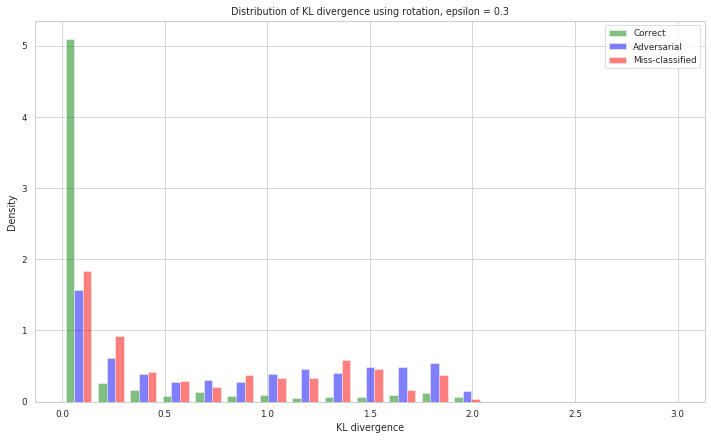

In [37]:
samples_correct_list = [sample[0] for sample in list(itertools.chain.from_iterable(samples_correct.values()))]
kl_div_correct_r_1 = get_l1_norm__augmentations(scaled_model,samples_correct_list, "r", 5)
samples_miss_list = [sample[0] for sample in list(itertools.chain.from_iterable(samples_missclass.values()))]
kl_div_missclass_r_1 = get_l1_norm__augmentations(scaled_model,samples_miss_list, "r", 5)
samples_adv_list = [sample[1][0] for sample in list(itertools.chain.from_iterable(good_adversarials.values()))]
kl_div_adv_r_1 = get_l1_norm__augmentations(scaled_model,samples_adv_list, "r", 5)

fig,ax = plt.subplots(figsize = (12,7))
ax.set_title("Distribution of KL divergence using rotation, epsilon = {}".format(0.3))
sns.set_context("paper")
plt.hist([kl_div_correct_r_1,kl_div_adv_r_1, kl_div_missclass_r_1,],bins = list(np.linspace(0,2,20)), color=['g','b','r'],density=True, alpha=0.5, label = ["Correct", "Adversarial", "Miss-classified"])
ax.set_xlabel("KL divergence")
ax.set_ylabel("Density")
ax.legend()

In [43]:
samples_correct_list = [sample[0] for sample in list(itertools.chain.from_iterable(samples_correct.values()))]
kl_div_correct_r_1 = detect_adversarials.get_kl_augmentations(scaled_model,samples_correct_list, "r", 1)
samples_miss_list = [sample[0] for sample in list(itertools.chain.from_iterable(samples_missclass.values()))]
kl_div_missclass_r_1 = get_kl_augmentations(scaled_model,samples_miss_list, "r", 1)
samples_adv_list = [sample[1][0] for sample in list(itertools.chain.from_iterable(good_adversarials.values()))]
kl_div_adv_r_1 = get_kl_augmentations(scaled_model,samples_adv_list, "r", 1)

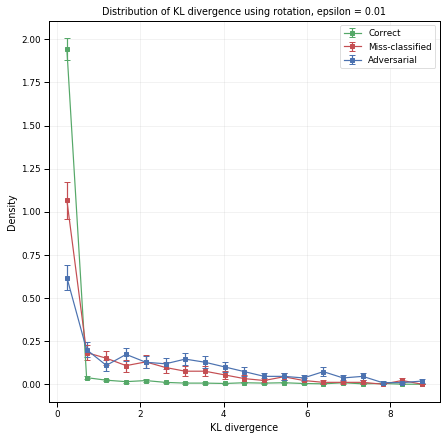

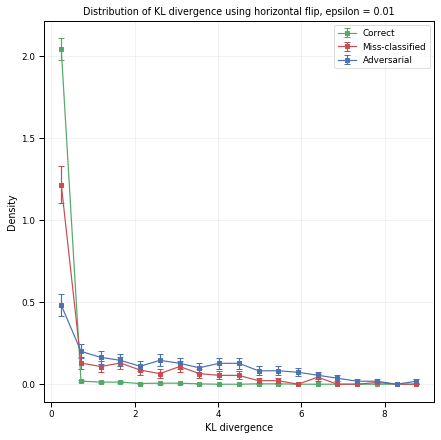

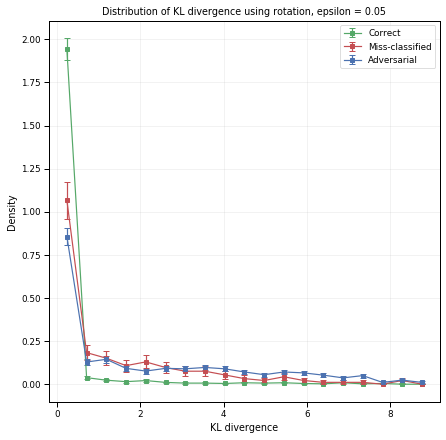

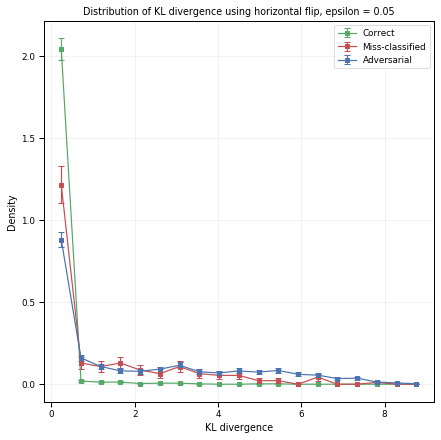

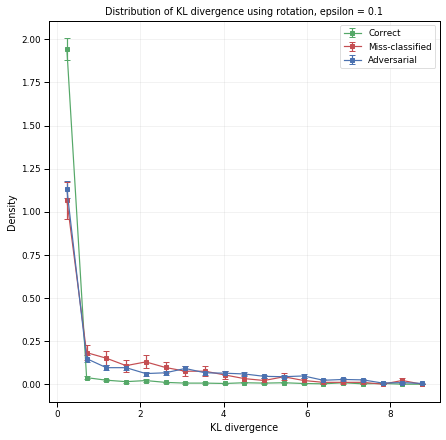

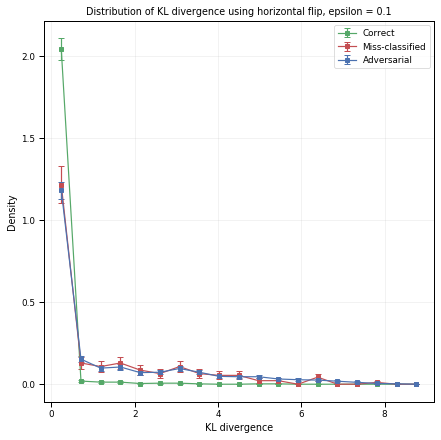

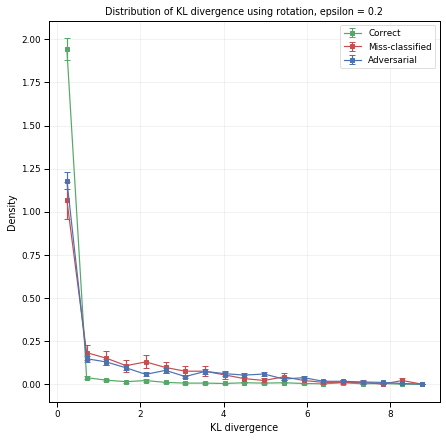

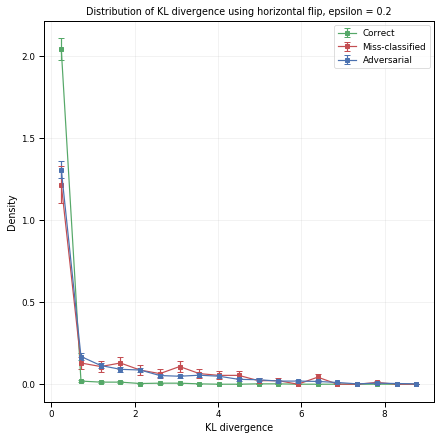

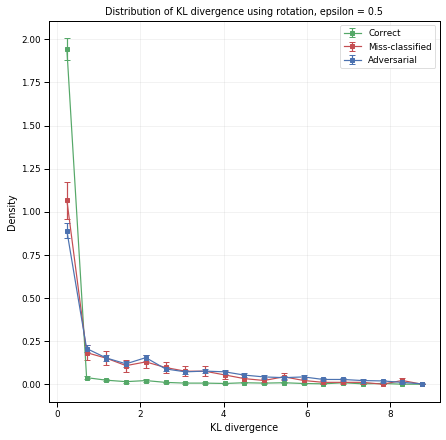

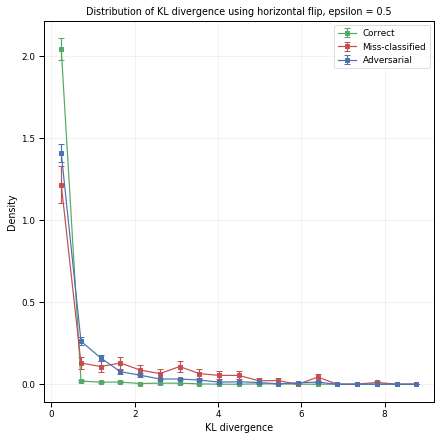

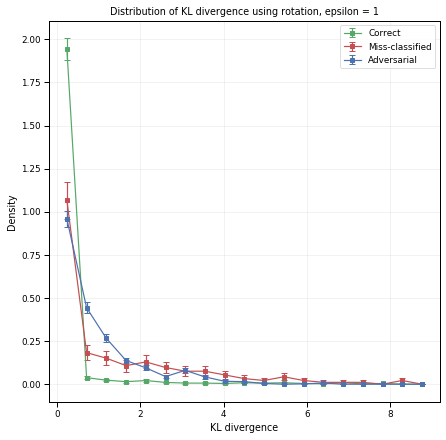

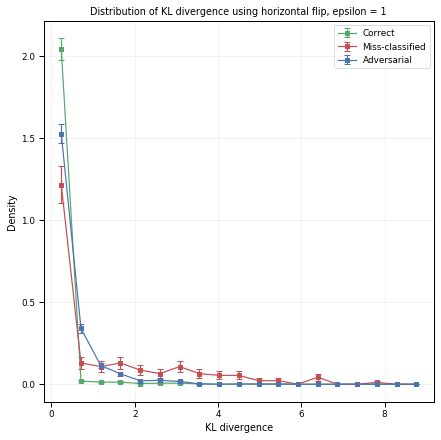

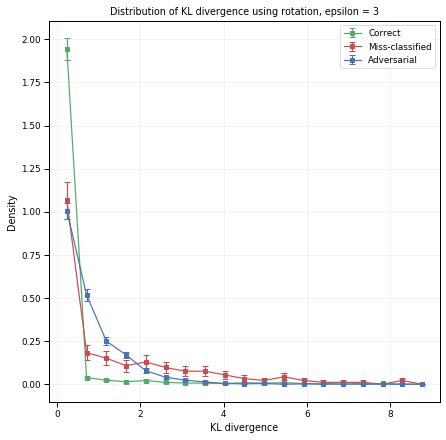

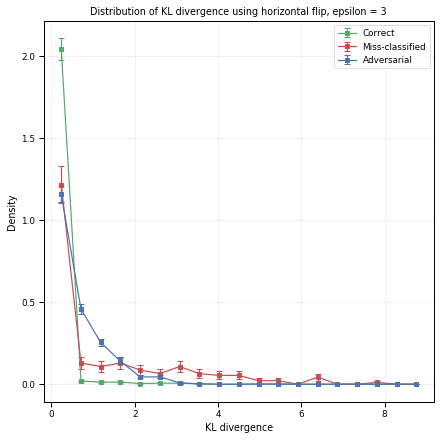

In [55]:
augmentations = [("rotation", "r"), ("horizontal flip", "fliplr")]
epsilons = [0.01, 0.05, 0.1, 0.2, 0.5, 1,3]

cur_aug = "rotation"
cur_eps = 0.3
kl_div_correct = {}
kl_div_missclass = {}
samples_correct_list = [sample[0] for sample in list(itertools.chain.from_iterable(samples_correct.values()))]
samples_miss_list = [sample[0] for sample in list(itertools.chain.from_iterable(samples_missclass.values()))]


for cur_augs in augmentations:
    kl_div_missclass[cur_augs[1]] = get_kl_augmentations(scaled_model,samples_miss_list, cur_augs[1], 1)
    kl_div_correct[cur_augs[1]] = get_kl_augmentations(scaled_model,samples_correct_list, cur_augs[1], 1)
    
for cur_eps in epsilons:
    good_adversarials = get_good_adversarial(model, testloader, epsilon= cur_eps, N = 100)
    samples_adv_list = [sample[1][0] for sample in list(itertools.chain.from_iterable(good_adversarials.values()))]
    for cur_augs in augmentations:
        
        kl_div_adv_r_1 = get_kl_augmentations(scaled_model,samples_adv_list, cur_augs[1], 1)
        
        sns.set_context("paper")
        fig,ax = plt.subplots(figsize = (7,7))
        ax.set_title("Distribution of KL divergence using {}, epsilon = {}".format(cur_augs[0], cur_eps))
        hist_errorbars(kl_div_correct[cur_augs[1]],normed = True,xerrs = False, bins = list(np.linspace(0,9,20)), color="#55A868", label="Correct")
        hist_errorbars(kl_div_missclass[cur_augs[1]],normed = True,xerrs = False, bins = list(np.linspace(0,9,20)), color="#C44E52", label="Miss-classified")
        hist_errorbars(kl_div_adv_r_1,normed = True,xerrs = False, bins = list(np.linspace(0,9,20)), color="#4C72B0", label="Adversarial")

        ax.grid(alpha = 0.2)
        ax.set_xlabel("KL divergence")
        ax.set_ylabel("Density")
        plt.legend()
        plt.show()
        plt.pause(0.01)